In [1]:
!rm -rf * .* 2>/dev/null
!rm -rf ~/.kaggle && mkdir ~/.kaggle
!echo eyJ1c2VybmFtZSI6InB2dHNlYzB4MSIsImtleSI6IjZlOTYxZmMxYjdhYzU2OTlmNzcwYmFjMjI1NTk4MWIwIn0= | base64 -d > ~/.kaggle/kaggle.json
!git clone https://github.com/Reshmavineesh/SunLit-Segmentation .
!git checkout dev
!./download_dataset.sh
from IPython.display import clear_output
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'; clear_output()
print("Dataset ready")

Dataset ready


In [2]:
import utils
import tensorflow as tf

image_path = 'dataset/dataset_tomato_128/color_images/'
mask_path = 'dataset/dataset_tomato_128/masks/'
n_val = 100

train_images, train_masks, test_images, test_masks = utils.load_dataset(image_path, mask_path, n_val)
print(f"Train Images:\t{train_images.shape}")
print(f"Train Masks:\t{train_masks.shape}")
print(f"Test Images:\t{test_images.shape}")
print(f"Test Masks:\t{test_masks.shape}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train Images:	(4748, 128, 128, 3)
Train Masks:	(4748, 128, 128)
Test Images:	(100, 128, 128, 3)
Test Masks:	(100, 128, 128)


In [3]:
from keras_models.models import FCDN103
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
loss=utils.dice_loss
metrics = ['accuracy']
input_shape = train_images.shape[1:]

train_attr = {
    "lr": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
    "optimizer": optimizer.get_config()['name'],
    "loss_fn": loss.get_config()['name']
}

n_layers_per_block = [4, 5, 7, 10, 12, 15]
n_classes = 1

model = FCDN103(n_classes, input_shape, num_layers_per_block=n_layers_per_block, dropout_rate=0.2, weight_decay=1e-4)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train_images,
                    train_masks,
                    validation_split = 0.4,
                    epochs = EPOCHS,
                    batch_size = BATCH_SIZE,
                    callbacks=[early_stopper])

Epoch 1/200
178/178 [==============================] - 175s 471ms/step - loss: 0.7314 - accuracy: 0.7826 - val_loss: 0.4840 - val_accuracy: 0.6939
Epoch 2/200
178/178 [==============================] - 76s 425ms/step - loss: 0.4868 - accuracy: 0.8156 - val_loss: 0.4394 - val_accuracy: 0.7823
Epoch 3/200
178/178 [==============================] - 75s 424ms/step - loss: 0.4663 - accuracy: 0.8192 - val_loss: 0.9593 - val_accuracy: 0.7521
Epoch 4/200
178/178 [==============================] - 76s 425ms/step - loss: 0.4564 - accuracy: 0.8210 - val_loss: 0.3985 - val_accuracy: 0.8066
Epoch 5/200
178/178 [==============================] - 75s 424ms/step - loss: 0.4487 - accuracy: 0.8239 - val_loss: 0.4532 - val_accuracy: 0.8184
Epoch 6/200
178/178 [==============================] - 75s 424ms/step - loss: 0.4413 - accuracy: 0.8261 - val_loss: 0.4819 - val_accuracy: 0.8066
Epoch 7/200
178/178 [==============================] - 75s 424ms/step - loss: 0.4489 - accuracy: 0.8231 - val_loss: 0.4820 

1/1 [==============================] - 0s 28ms/step


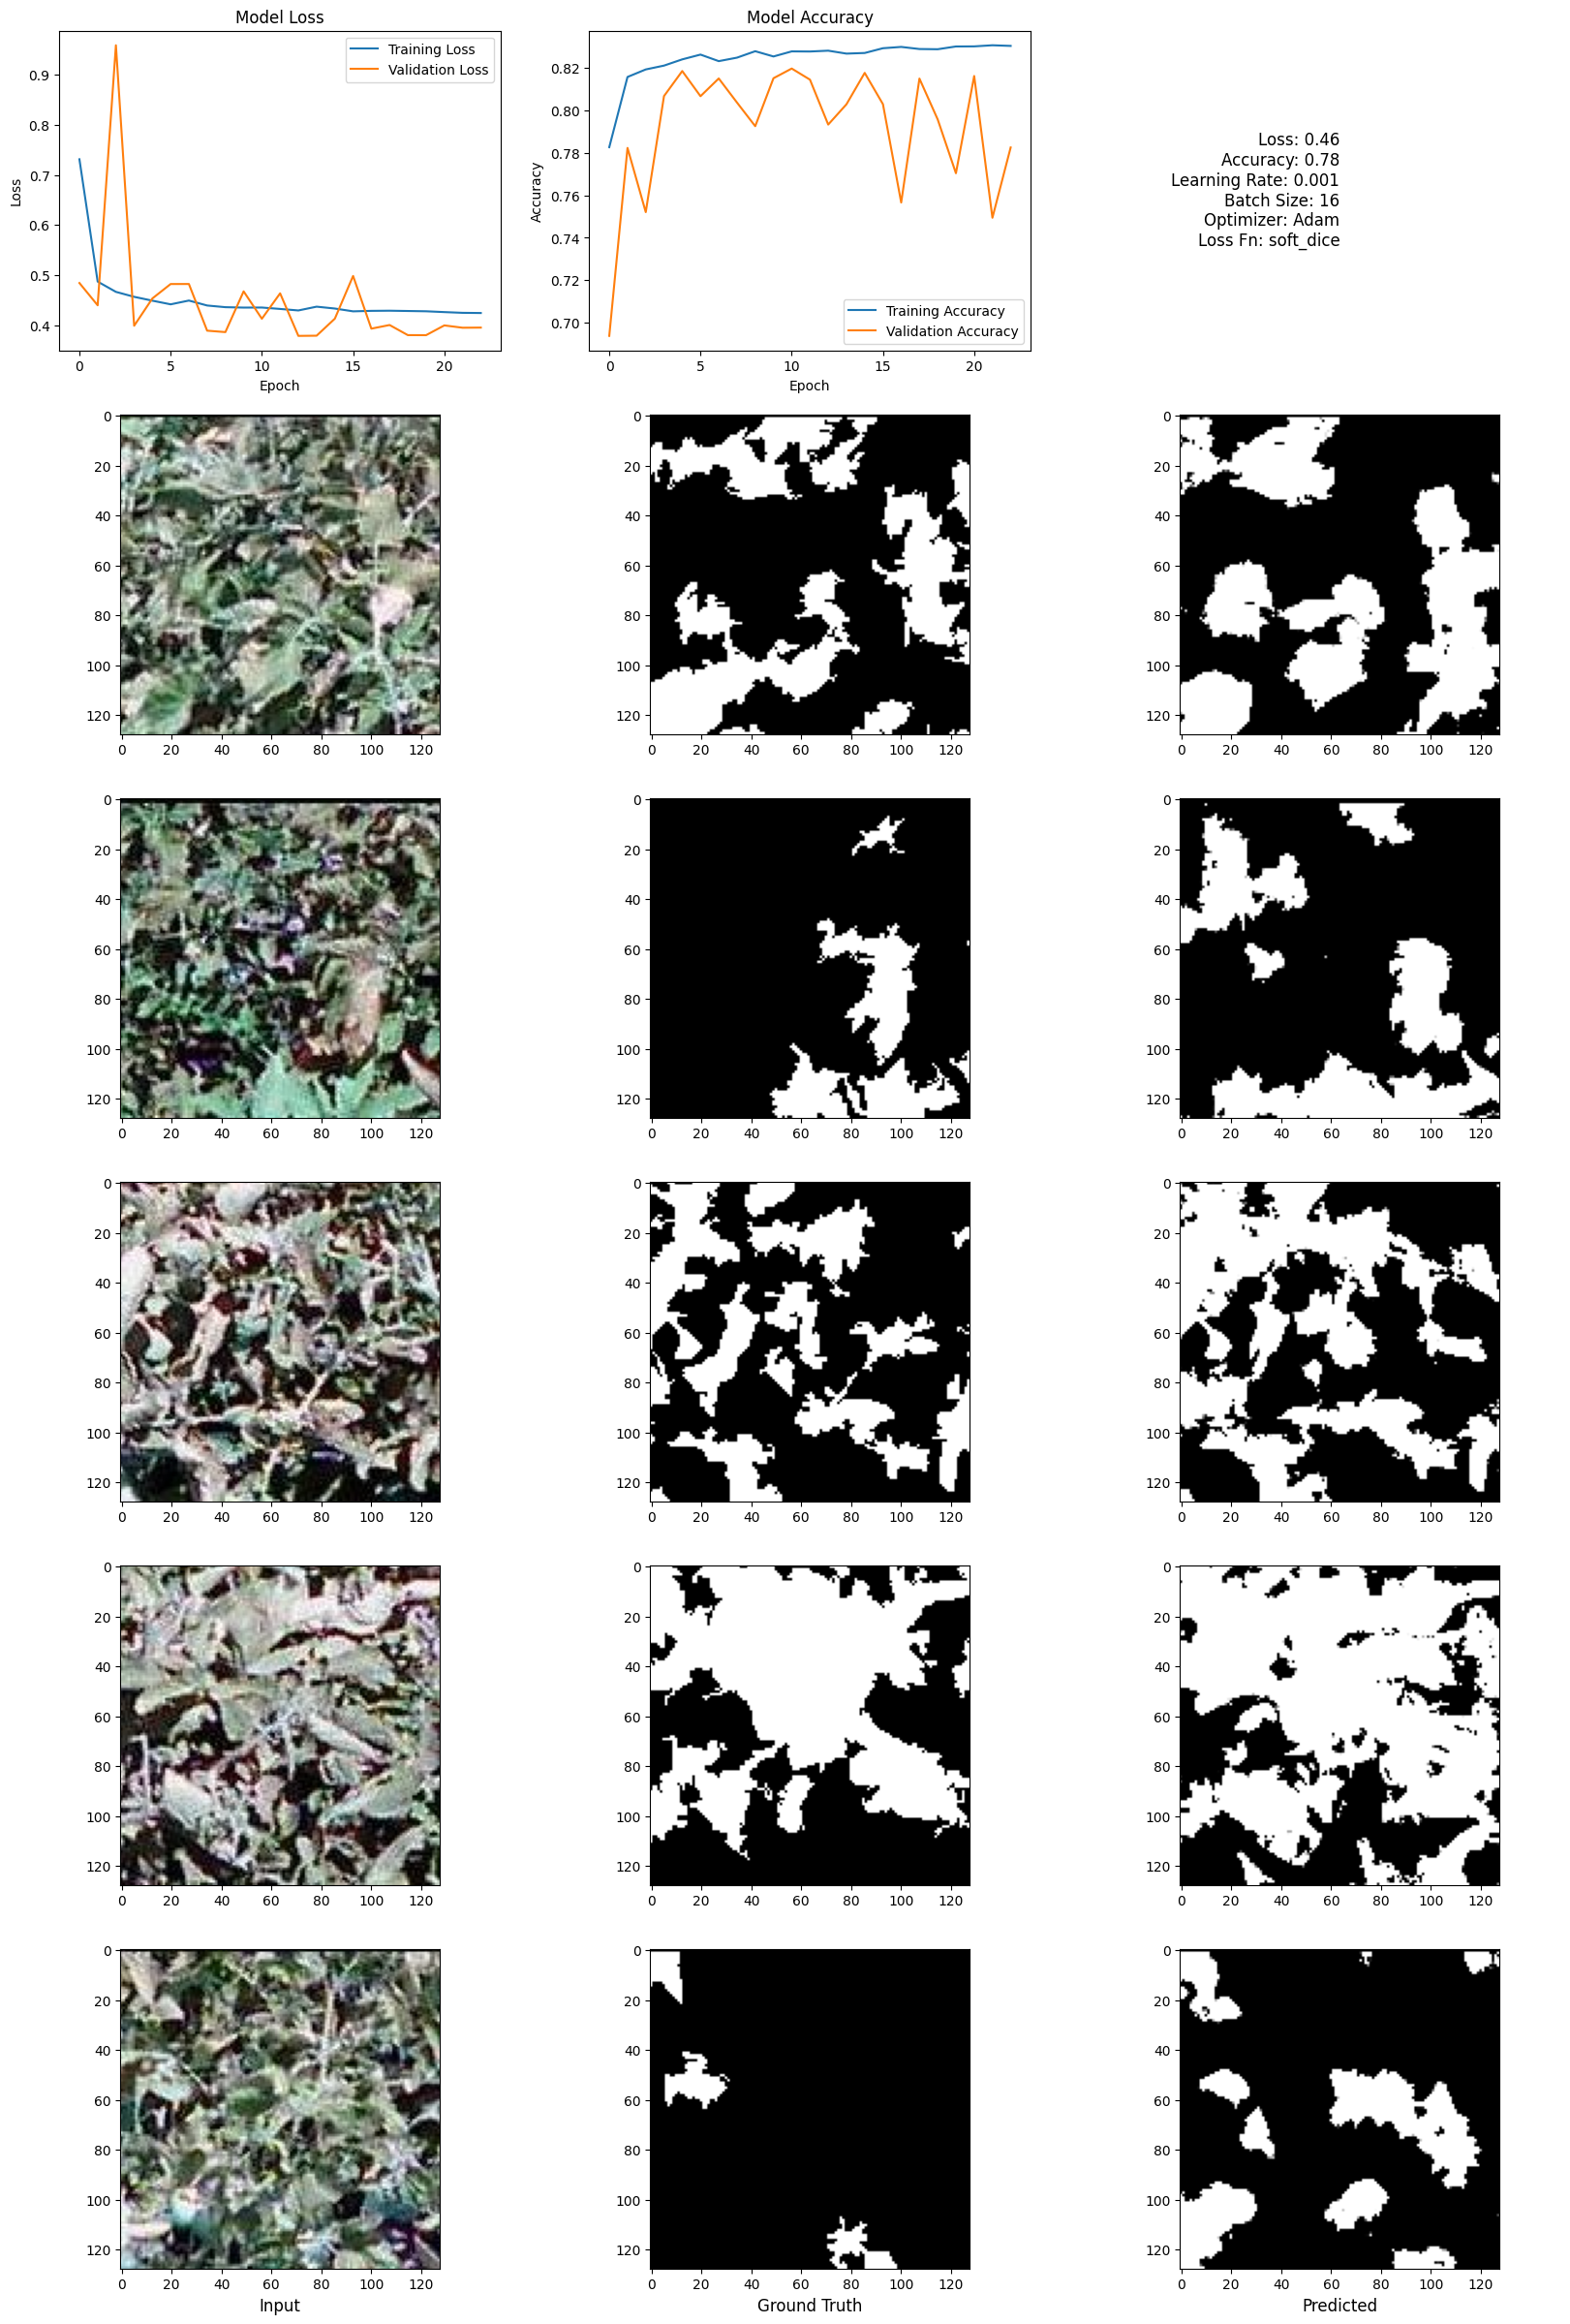

In [4]:
utils.analyzer(history, model, image_path, mask_path, test_images, test_masks, train_attr)